### Create centroids from polygons for graduated symbol mapping
To do this we'll need to project to polygon back to a projected CRS

In [3]:
# import all the libraries
import numpy as np
import matplotlib as mp
import fiona
import shapely
from shapely.geometry import Polygon, LineString, Point
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rasterstats as rs
import matplotlib.pyplot as plt
from rasterio.plot import show
import mapclassify
from functools import reduce

#change default figure size
plt.rcParams['figure.figsize'] = (12,12)

# show all columns
pd.set_option("display.max_columns", None)

In [6]:
# read in cdps_svis_whp shapefile as dataframe
cdps_svis_whp = gpd.read_file(r'C:\NewMapsPlus\Map698\us-communities-fire\notebooks\data\cdps_svis_whp.shp')

In [7]:
# verify the object type
type(cdps_svis_whp)

geopandas.geodataframe.GeoDataFrame

In [9]:
# get a sample of the data
cdps_svis_whp.sample()

,GEOID,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,AFFGEOID_x,NAME_x,NAMELSAD_x,STUSPS_x,STATE_NAME,Acres_x,whp_score,se_wm,hcd_wm,m_wm,htt_wm,overall_wm,geometry
606,0638702,06,CALIFORNIA,CA,06015,Del Norte,06015000203,"Census Tract 2.03, Del Norte County, California",142.368516,1600000US0638702,Klamath,Klamath CDP,CA,California,11001.601876,4.0,0.9126,0.8845,0.4485,0.9635,0.941,"POLYGON ((-124.09503 41.59129, -124.09048 41.5..."


#### Project geodataframe for overlay analysis

In [12]:
# check the crs - it's wgs84
cdps_svis_whp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
# set a variable with parameters for USA Contiguous Equidistant
project_params  = '+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'

# reproject and assign to new variables
cdps_svis_whp_ec = cdps_svis_whp.to_crs(project_params)

In [28]:
# # check the crs - it's Equidistant Conic
cdps_svis_whp_ec.crs

<Projected CRS: +proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=4 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Equidistant Conic
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [29]:
# get a sample of the reprojected data
cdps_svis_whp_ec.sample()

,GEOID,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,AFFGEOID_x,NAME_x,NAMELSAD_x,STUSPS_x,STATE_NAME,Acres_x,whp_score,se_wm,hcd_wm,m_wm,htt_wm,overall_wm,geometry
76,0135752,01,ALABAMA,AL,01051,Elmore,01051030200,"Census Tract 302, Elmore County, Alabama",108.426323,1600000US0135752,Holtville,Holtville CDP,AL,Alabama,16119.064809,3.0,0.753459,0.320586,0.33658,0.824728,0.677009,"POLYGON ((911924.691 -658676.371, 912225.324 -..."


In [32]:
# change the variable name referencing center 'ctr' for later use
cdps_svis_whp_ec = cdps_svis_whp_ctr

In [33]:
# convert polygon data to centroid 
cdps_svis_whp_ctr['geometry'] = cdps_svis_whp_ctr['geometry'].centroid

In [34]:
# get a sample of the centroids and notice that the geometry is now point
cdps_svis_whp_ctr.sample()

,GEOID,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,AFFGEOID_x,NAME_x,NAMELSAD_x,STUSPS_x,STATE_NAME,Acres_x,whp_score,se_wm,hcd_wm,m_wm,htt_wm,overall_wm,geometry
2044,3676331,36,NEW YORK,NY,36059,Nassau,36059517701,"Census Tract 5177.01, Nassau County, New York",14.437381,1600000US3676331,Upper Brookville,Upper Brookville village,NY,New York,2752.095615,4.0,0.018628,0.113787,0.534305,0.177234,0.078058,POINT (1863649.800 435531.928)


[Text(0.5, 1.0, 'CDPS and SVI Tracts')]

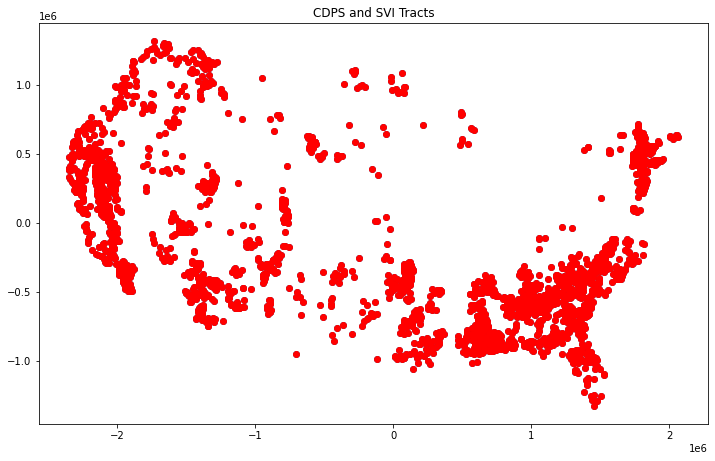

In [35]:
# overlay reprojected cdps on reprojected svis
fig, ax = plt.subplots()

cdps_svis_whp_ec.plot(ax=ax, zorder=1);
cdps_svis_whp_ctr.plot(ax=ax, color='red', zorder=2);

ax.set(title='CDPS and SVI Tracts')

In [ ]:
# plot the resulting dataframe interactively
cdps_svis_whp_pts.explore(tooltip=['GEOID','NAMELSAD_x', 'whp_score', 'se_wm','hcd_wm','m_wm','htt_wm','overall_wm'])